In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23')

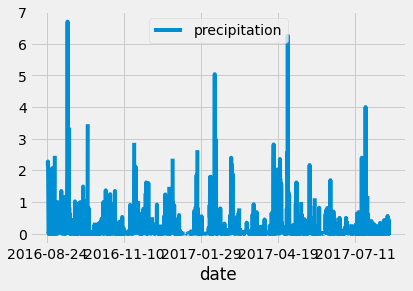

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.

recent_point = dt.date(2017,8,23) - dt.timedelta(days=365)
recent_point

# Perform a query to retrieve the data and precipitation scores

prcp_scores = session.query(Measurement.date, Measurement.prcp).\
                  filter(Measurement.date > "2016-08-23").all()


# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

prcp_df = pd.DataFrame(prcp_scores, columns=["date", "precipitation"])
prcp_df.set_index('date', inplace=True)
prcp_df.sort_index(inplace=True)
#prcp_df.head()

# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot()



In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()


precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset

session.query(Station.id).distinct().count()


9

In [31]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by((func.count(Measurement.station).desc())).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [37]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

temps = [func.min(Measurement.tobs), 
    func.max(Measurement.tobs), 
    func.avg(Measurement.tobs)]
         
active_station_temps = session.query(*temps).\
    filter(Measurement.station == "USC00519281").all()


[(54.0, 85.0, 71.66378066378067)]

In [64]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query to know last date for most active station
last_date = session.query(Measurement.date).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date.desc()).first()
last_date

('2017-08-18')

In [67]:
# Use last_date o filter danta an create dataframe and use Read SQL query into a DataFrame.


max_tobs_stn = pd.DataFrame(session.query(Measurement.date,Measurement.tobs).\
             filter(Measurement.date >= "2017-08-18").\
             filter(Measurement.station == "USC00519281" ).\
                            order_by(Measurement.date).all())

obs_data_df = pd.read_sql_query(stmt, session.bind)
obs_data_df

id      station        date  prcp  tobs
0    14604  USC00519281  2016-08-19  0.31  79.0
1    14605  USC00519281  2016-08-20  0.13  81.0
2    14606  USC00519281  2016-08-21  0.08  79.0
3    14607  USC00519281  2016-08-22  2.32  78.0
4    14608  USC00519281  2016-08-23  1.79  77.0
..     ...          ...         ...   ...   ...
351  14955  USC00519281  2017-08-14  0.00  77.0
352  14956  USC00519281  2017-08-15  0.32  77.0
353  14957  USC00519281  2017-08-16  0.12  76.0
354  14958  USC00519281  2017-08-17  0.01  76.0
355  14959  USC00519281  2017-08-18  0.06  79.0

[356 rows x 5 columns]

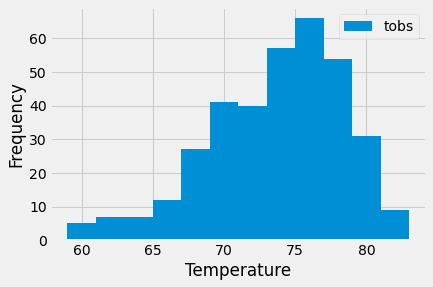

In [68]:
# plot data

obs_data_df.hist(column="tobs", bins = 12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.legend(["tobs"], loc = "upper right")
plt.title("")
plt.show()

# Close session

In [16]:
# Close Session
session.close()